# Analyse Entity Mentions

In [1]:
from utils.preprocessing import *
from utils.accelerators import *
from utils.multithreading import *
from utils.database import *
from utils.model import *
from utils.files import *

from tqdm import tqdm
import numpy as np

/home/jschelb/.pyenv/versions/3.10.8/envs/mediacloud/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Questions:**

- How many entities/persons are mentioned per article?
- Are there articles with only a few entities mentioned?
- Does the number of entity mentions correlate with the number of "None" values?

## Connect to DB

In [2]:
_, db = getConnection(use_dotenv=True)

## Sample Articles

In [3]:
documents = list(db.articles.sampled.triplets.aggregate([
    {'$sample': {'size': 10_000}}
]))

In [4]:
print(documents[0].get("parsing_result").get("text"))

e-Edition Sign up for email newsletters  Sign up for email newsletters e-Edition Related Articles
Letters to the Editor |  

			Letter | The term ‘silver tsunami’ implies action		


Letters to the Editor |  

			Letter | Rep. Panetta supporters’ false accusations		


Letters to the Editor |  

			Letter | A bad night in unprotected emergency room		


Letters to the Editor |  

			Letter | Misguided ‘woke’ ideology about water in Maui		


Letters to the Editor |  

			Letter | Robo cashiers and now robo doctors Greg Hyver has asked “Where was Leopold?” The ability for Greg to attend the SCSC Round Table meetings to voice his opinion is because of Supervisor Leopold. Leopold worked tirelessly for us as a voting member of the Select Committee. Leopold framed the language that allowed the FAA to agree to return the SERFR pathway to its historical track. Progress continues to be made as the FAA works through the internal processes. Greg blames Leopold for the condition of his road; instead 

## Detect Entities Mentioned

In [5]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_trf")


In [6]:
# Set of entity types you are interested in
interested_entities = {"PERSON", "NORP", "ORG", "GPE", "EVENT"}

In [7]:
for document in tqdm(documents):
    try:
        text = document.get("parsing_result").get("text", "")[:100_000]
        
        # Process whole documents
        text = text.replace("\n", " ")
        doc = nlp(text)

        # Filter entities in the document 
        filtered_entities = [{'text': ent.text, 'type': ent.label_} for ent in doc.ents if ent.label_ in interested_entities]
        document["extracted_entities"] = filtered_entities
    except Exception as e:
        print(e)
        document["extracted_entities"] = []


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [1:03:36<00:00,  2.62it/s]


In [8]:
documents[0]["extracted_entities"][:10]

[{'text': 'Panetta', 'type': 'PERSON'},
 {'text': 'Maui', 'type': 'GPE'},
 {'text': 'Greg Hyver', 'type': 'PERSON'},
 {'text': 'Leopold', 'type': 'PERSON'},
 {'text': 'Greg', 'type': 'PERSON'},
 {'text': 'SCSC Round Table', 'type': 'ORG'},
 {'text': 'Leopold', 'type': 'PERSON'},
 {'text': 'Leopold', 'type': 'PERSON'},
 {'text': 'the Select Committee', 'type': 'ORG'},
 {'text': 'Leopold', 'type': 'PERSON'}]

In [9]:
import json
from bson import ObjectId


# A helper function to convert ObjectId and potentially other BSON types
def json_converter(o):
    if isinstance(o, ObjectId):
        return str(o)

# Convert documents to a JSON string, handling ObjectId
json_data = json.dumps(documents, default=json_converter, indent=4)

# Save to disk
file_path = './data/entity_mentions.json'  # Adjust path as needed
with open(file_path, 'w') as file:
    file.write(json_data)

print(f"Saved documents to {file_path}")


Saved documents to ./data/entity_mentions.json


## Analyse

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import json 

**Load Entities:**

In [2]:
file_path = './data/entity_mentions.json'  # Adjust path 

# Read from disk
with open(file_path, 'r') as file:
    documents = json.load(file)


In [3]:
na_values = ['None',
             'N/A',
             "'None'",
             'Unknown',
             'No one',
             'Name',
             'Villain not identified',
             'None}',
             "'None'}",
             'no hero identified',
             'no hero',
             'villain not applicable',
             'none.',
             'villain (none)']

**Count "None" values:**

In [4]:
for document in documents:
    
    # Extract the entities from the triplets
    triplet = document.get("triplets", {})[0].get("answers", [])[0].get("triplet", {})
    entities_extracted = [ent.lower() for ent in list(triplet.values())]
    none_count = sum([entities_extracted.count(value.lower()) for value in na_values])
    document["num_entities_extracted"] = len(document["extracted_entities"])
    document["contains_none"] = none_count > 0
    document["none_count"] = none_count

print("Number of entities extracted:", documents[0].get("num_entities_extracted"))
print("Contains 'None':", documents[0].get("contains_none"))
print("Count of 'None':", documents[0].get("none_count"))


Number of entities extracted: 24
Contains 'None': True
Count of 'None': 1


In [5]:
#documents = [doc for doc in documents if doc.get("parsing_result", {}).get("word_count", 0) > 10]
#print("Number of documents with word count:", len(documents))

**Calculate Averages of entities found:**

In [6]:
# Initialize a dictionary to store total entities count and document count for each none_count value
none_count_stats = defaultdict(lambda: {'total_entities': 0, 'doc_count': 0})

# Iterate over each document to update the stats
for document in documents:
    none_count = document["none_count"]
    num_entities = len(document["extracted_entities"])
    none_count_stats[none_count]['total_entities'] += num_entities
    none_count_stats[none_count]['doc_count'] += 1

# Calculate and print the average for each none_count value
averages = {none_count: stats['total_entities'] / stats['doc_count'] for none_count, stats in none_count_stats.items() if stats['doc_count'] > 0}

# Print averages in sorted order
for none_count, avg in sorted(averages.items(), key=lambda x: x[0], reverse=False):
    print(f"None count: {none_count} - Average entities: {avg:.2f}")


None count: 0 - Average entities: 54.40
None count: 1 - Average entities: 63.40
None count: 2 - Average entities: 40.13
None count: 3 - Average entities: 32.80


**Plot Distribution:**

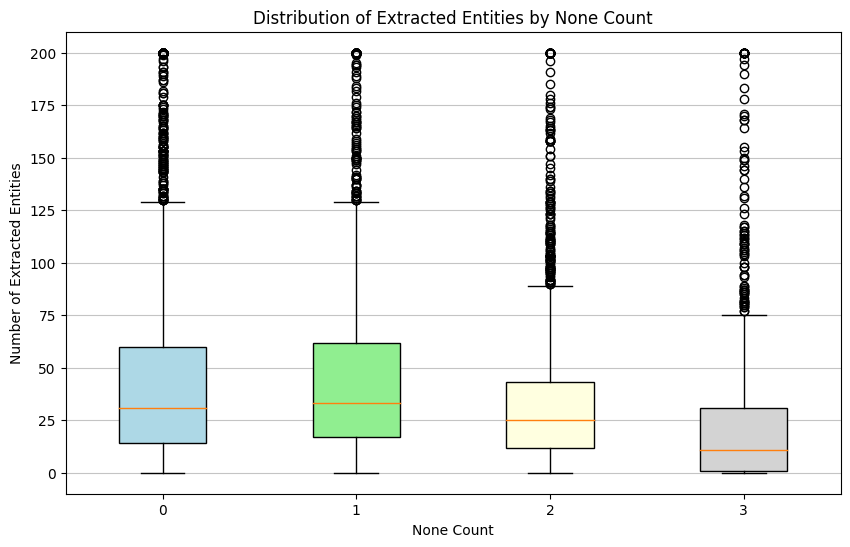

In [7]:
# Aggregating data
data_by_none_count = {}
for document in documents:
    none_count = document["none_count"]
    num_entities = min(len(document["extracted_entities"]), 200)
    if none_count not in data_by_none_count:
        data_by_none_count[none_count] = []
    data_by_none_count[none_count].append(num_entities)

# Sorting data by none count
sorted_data_by_none_count = dict(sorted(data_by_none_count.items()))

# Preparing data for the plot
labels, data = zip(*sorted_data_by_none_count.items())  # 'labels' are the sorted none counts, 'data' is the sorted list of lists of num_entities

# Creating the box and whisker plot with colors
plt.figure(figsize=(10, 6))
boxplots = plt.boxplot(data, labels=labels, patch_artist=True)

# Adding colors
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral']
for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribution of Extracted Entities by None Count')
plt.xlabel('None Count')
plt.ylabel('Number of Extracted Entities')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Plot Averages:**

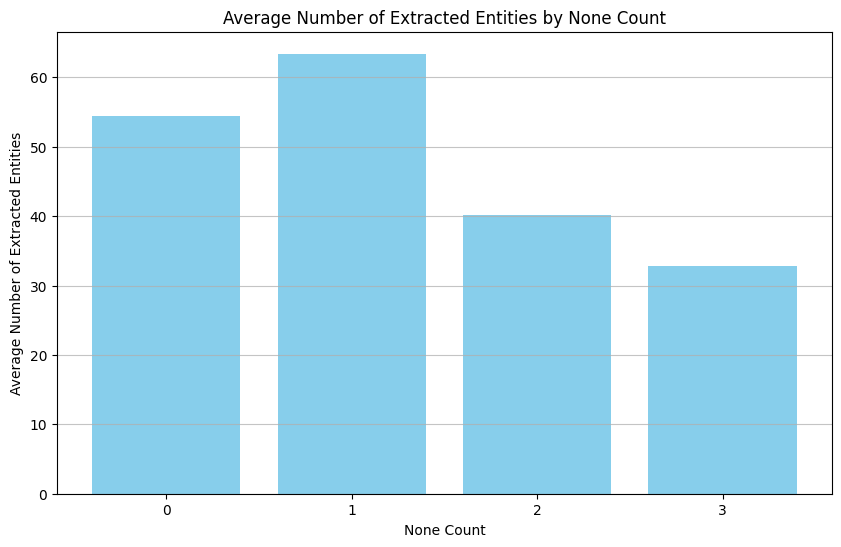

In [8]:
# Extracting none count values and their corresponding averages
sorted_averages = dict(sorted(averages.items()))
none_counts = list(sorted_averages.keys())
average_values = [sorted_averages[none_count] for none_count in none_counts]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(none_counts, average_values, color='skyblue')
plt.title('Average Number of Extracted Entities by None Count')
plt.xlabel('None Count')
plt.ylabel('Average Number of Extracted Entities')
plt.xticks(none_counts)  # Ensure x-ticks match the none count values
plt.grid(axis='y', alpha=0.75)
plt.show()

**Word count and document length:**

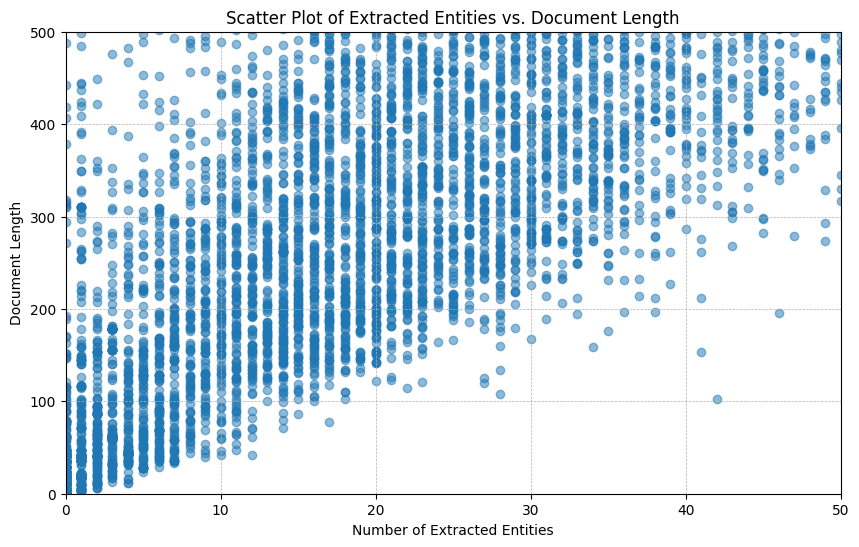

In [9]:
# Extracting "none_count" for each document
none_counts = [document["none_count"] for document in documents]

# Extracting data for the plot
x_data = [len(document["extracted_entities"]) for document in documents]  # Number of entities
y_data = [document.get("parsing_result", {}).get("word_count", 0) for document in documents]  # Document length

# Creating the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x_data, y_data, alpha=0.5)
#plt.colorbar(scatter, label='None Count')
plt.title('Scatter Plot of Extracted Entities vs. Document Length')
plt.xlabel('Number of Extracted Entities')
plt.ylabel('Document Length')
plt.xlim(0, 50)  # Limiting the x-axis to 2000 entities
plt.ylim(0, 500)  # Limiting the y-axis to 40,000 word count
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [10]:
# List to hold the count of entities for each document
entity_counts_none_count_0 = []
entity_counts_none_count_more_than_0 = []

# Iterate over each document and count the entities
for document in documents:
    num_entities = len(document["extracted_entities"])
    if document["none_count"] == 0:
        entity_counts_none_count_0.append(num_entities)
    else:
        entity_counts_none_count_more_than_0.append(num_entities)

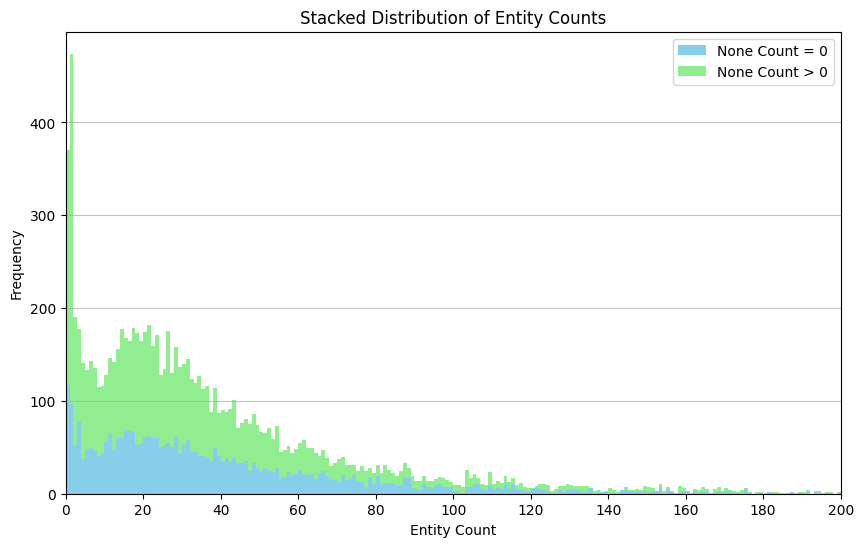

In [77]:
# Plotting the distributions in the same plot with stacking
plt.figure(figsize=(10, 6))

# Combine the data for setting the bins consistently
combined_data = entity_counts_none_count_0 + entity_counts_none_count_more_than_0
bins = range(min(combined_data), max(combined_data) + 2)

# Using hist function with stacked=True to create stacked histograms
plt.hist([entity_counts_none_count_0, entity_counts_none_count_more_than_0], bins=bins, color=['skyblue', 'lightgreen'], stacked=True, label=['None Count = 0', 'None Count > 0'])

plt.title('Stacked Distribution of Entity Counts')
plt.xlabel('Entity Count')
plt.ylabel('Frequency')
plt.xlim([0, 200])  # Limiting the x-axis to 200
plt.xticks(range(0, 201, 20))  # Adjusting x-axis ticks for better readability
plt.grid(axis='y', alpha=0.75)
plt.legend()  # Show legend to differentiate the distributions
plt.show()

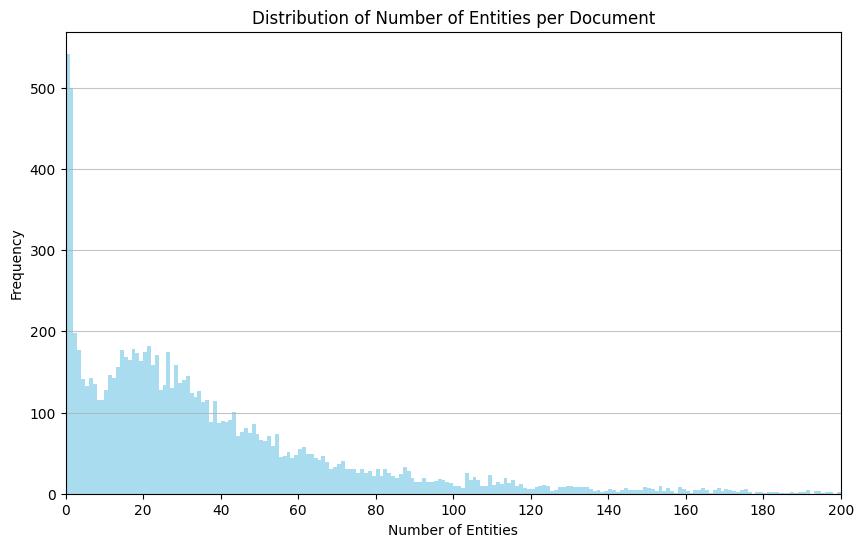

In [8]:
import matplotlib.pyplot as plt 

# List to hold the count of entities for each document
entity_counts_per_document = []

# Iterate over each document and count the entities
for document in documents:
    num_entities = len(document["extracted_entities"])
    entity_counts_per_document.append(num_entities)

# Plotting the distribution with x-axis limit
plt.figure(figsize=(10, 6))
plt.hist(entity_counts_per_document, bins=range(min(entity_counts_per_document), max(entity_counts_per_document) + 2), color='skyblue', alpha=0.7)
plt.title('Distribution of Number of Entities per Document')
plt.xlabel('Number of Entities')
plt.ylabel('Frequency')
plt.xlim([0, 200])  # Limiting the x-axis to 200
plt.xticks(range(0, 201, 20))  # Adjusting x-axis ticks for better readability
plt.grid(axis='y', alpha=0.75)
plt.show()

In [15]:
import random

random.shuffle(documents)

In [34]:
docs_many_entities = [doc for doc in documents if doc.get("num_entities_extracted", 0) > 100 and doc.get("none_count", 0) > 2]
sorted_docs_many_entities = sorted(docs_many_entities, key=lambda doc: doc["num_entities_extracted"])
print("Number of documents with more than 100 entities:", len(docs_many_entities), "\n")

for doc in docs_many_entities[:5]:
    print(doc.get("title", ""))
    print(doc.get("url", ""))
    print(doc.get("parsing_result", {}).get("url", ""))
    print(doc.get("extracted_entities", [])[:5])
    print("Triplet:", doc.get("triplets", [])[0].get("answers", [])[0].get("triplet", {}))
    print("Text:", doc.get("parsing_result", {}).get("text", "")[:15_000])
    print("\n")

Number of documents with more than 100 entities: 69 

The 45 Accounts Donald Trump Follows On Twitter (NYSE: TWTR)
https://www.benzinga.com/general/education/17/09/9996221/the-45-accounts-donald-trump-follows-on-twitter

[{'text': 'Donald Trump', 'type': 'PERSON'}, {'text': 'the United States', 'type': 'GPE'}, {'text': 'Twitter Inc', 'type': 'ORG'}, {'text': 'Twitter', 'type': 'ORG'}, {'text': 'Tucker Carlson', 'type': 'PERSON'}]
Triplet: {'hero': 'None', 'villain': 'None', 'victim': 'None}'}
Text: President Donald Trump is the 45th president of the United States, and coincidence or not, he follows 45 profiles on Twitter Inc TWTR. The president's use of Twitter has been a source of controversy, but he continues to believe that using the social media platform gives him a direct line of communication to the world without the "fake media" twisting his comments around. Here is a list of the 45 profiles the president via @realDonaldTrump follows, in no particular order. 1. Tucker Carlson: C

In [35]:
docs_many_entities = [doc for doc in documents if doc.get("num_entities_extracted", 0) < 10 and doc.get("none_count", 0) == 0]
sorted_docs_many_entities = sorted(docs_many_entities, key=lambda doc: doc["num_entities_extracted"])
print("Number of documents with more than 100 entities:", len(docs_many_entities))

for doc in docs_many_entities[:2]:
    print(doc.get("title", ""))
    print(doc.get("url", ""))
    print(doc.get("extracted_entities", [])[:5])
    print("Triplet:", doc.get("triplets", [])[0].get("answers", [])[0].get("triplet", {}))
    print("Text:", doc.get("parsing_result", {}).get("text", "")[:15_000])
    print("\n")

Number of documents with more than 100 entities: 669
NYT admits the 17-intelligence agencies Russian hacking narrative was FAKE!!!
http://rinf.com/alt-news/newswire/nyt-admits-the-17-intelligence-agencies-russian-hacking-narrative-was-fake/
[{'text': 'D.C.', 'type': 'GPE'}, {'text': 'New York Times', 'type': 'ORG'}, {'text': 'Russian', 'type': 'NORP'}, {'text': 'Stefan Molyneux', 'type': 'PERSON'}]
Triplet: {'hero': 'Stefan Molyneux', 'villain': 'NYT', 'victim': '17-intelligence agencies'}
Text:  DCWhispers.comJune 30, 2017 Of course the retraction takes place quietly before the 4th of July holiday. Nothing to see here folks. Just a false narrative that was repeated over and over and over again by D.C. politicians and the media. It was a lie. A total exaggerated falsehood. AGAIN. New York Times finally admits that the 17-intelligence agencies Russian hacking narrative was a complete falsehood! https://t.co/Z2Pm19X9rQ pic.twitter.com/mVNpAkRnzx — Stefan Molyneux (@StefanMolyneux) June 2

### Question: What are the most mentioned entities?

In [78]:
from collections import defaultdict

# Initialize a defaultdict to count appearances
entity_counts = defaultdict(int)

# Loop over the documents to aggregate entity counts
for document in tqdm(documents):
    extracted_entities = document.get("extracted_entities", [])
    for entity in extracted_entities:
        # Create a unique key for each entity + label combination
        key = (entity['text'], entity['type'])
        entity_counts[key] += 1

# Sort the entities by their count in descending order
sorted_entities = sorted(entity_counts.items(), key=lambda item: item[1], reverse=True)

# Print the top 10 entities
print("Top 10 entities by appearance:")
for (entity_text, entity_type), count in sorted_entities[:10]:
    print(f"Entity: {entity_text}, Type: {entity_type}, Count: {count}")


  0%|          | 0/9794 [00:00<?, ?it/s]

100%|██████████| 9794/9794 [00:00<00:00, 19798.04it/s]


Top 10 entities by appearance:
Entity: Trump, Type: PERSON, Count: 10962
Entity: U.S., Type: GPE, Count: 4301
Entity: US, Type: GPE, Count: 3178
Entity: Biden, Type: PERSON, Count: 2754
Entity: China, Type: GPE, Count: 2585
Entity: Republican, Type: NORP, Count: 2554
Entity: American, Type: NORP, Count: 2459
Entity: America, Type: GPE, Count: 2145
Entity: Democrats, Type: NORP, Count: 2119
Entity: Donald Trump, Type: PERSON, Count: 2072


### Question: How many entities/persons are mentioned per article on average?

In [79]:
total_person_mentions = 0
total_articles = len(documents)

# Count only "PERSON" entity mentions per document
for document in documents:
    person_mentions = sum(1 for entity in document.get("extracted_entities", []) if entity['type'] == 'PERSON')
    total_person_mentions += person_mentions

# Calculate the average number of "PERSON" mentions per article
average_person_mentions_per_article = total_person_mentions / total_articles if total_articles > 0 else 0

print(f"Average number of 'PERSON' mentions per article: {average_person_mentions_per_article}")

Average number of 'PERSON' mentions per article: 19.779048396977743


In [80]:
import numpy as np

# First, we'll calculate the number of each entity type per document.
entity_type_counts_per_doc = defaultdict(list)

for document in documents:
    # Initialize a count for each entity type in this document
    doc_type_counts = defaultdict(int)
    for entity in document.get("extracted_entities", []):
        doc_type_counts[entity['type']] += 1
    
    # For each entity type, append this document's count to the appropriate list
    for entity_type, count in doc_type_counts.items():
        entity_type_counts_per_doc[entity_type].append(count)
        
# For calculating min, max, std, and avg per entity type
stats_per_entity_type = {}

for entity_type, counts in entity_type_counts_per_doc.items():
    # Calculating statistics
    min_count = min(counts)
    max_count = max(counts)
    std_dev = np.std(counts)
    avg_count = np.mean(counts)
    
    # Storing statistics
    stats_per_entity_type[entity_type] = {
        'min': min_count,
        'max': max_count,
        'std': std_dev,
        'avg': avg_count
    }

# Display the calculated statistics
for entity_type, stats in stats_per_entity_type.items():
    print(f"Statistics for '{entity_type}' Entities per Document:")
    print(f"  Minimum: {stats['min']}")
    print(f"  Maximum: {stats['max']}")
    print(f"  Standard Deviation: {stats['std']:.2f}")
    print(f"  Average: {stats['avg']:.2f}\n")


Statistics for 'PERSON' Entities per Document:
  Minimum: 1
  Maximum: 1426
  Standard Deviation: 55.20
  Average: 23.80

Statistics for 'GPE' Entities per Document:
  Minimum: 1
  Maximum: 844
  Standard Deviation: 29.75
  Average: 12.99

Statistics for 'ORG' Entities per Document:
  Minimum: 1
  Maximum: 854
  Standard Deviation: 30.93
  Average: 16.66

Statistics for 'NORP' Entities per Document:
  Minimum: 1
  Maximum: 782
  Standard Deviation: 23.58
  Average: 8.70

Statistics for 'EVENT' Entities per Document:
  Minimum: 1
  Maximum: 80
  Standard Deviation: 4.10
  Average: 2.92



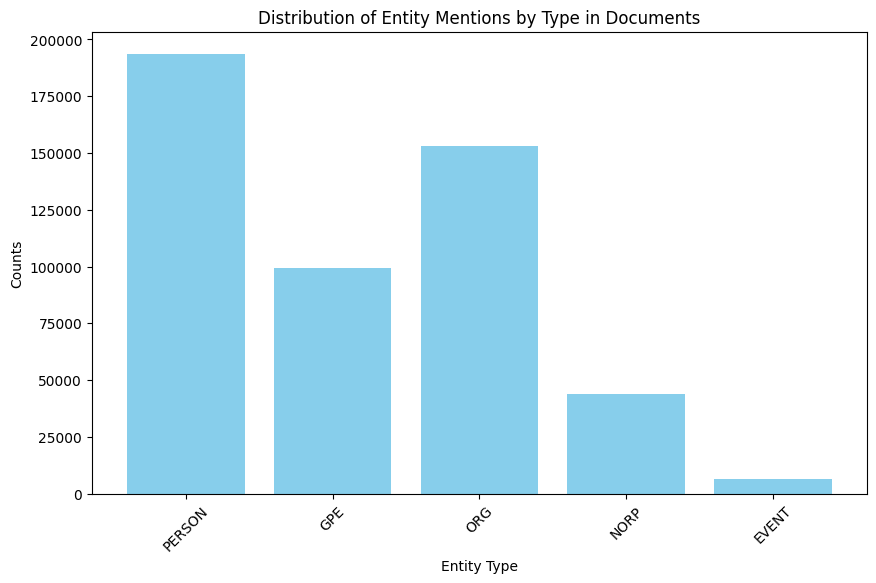

In [81]:
import matplotlib.pyplot as plt

# Initialize a defaultdict to aggregate counts by type
type_counts = defaultdict(int)
for (_, entity_type), count in entity_counts.items():
    type_counts[entity_type] += count

# Data for plotting
types = list(type_counts.keys())
counts = [type_counts[type] for type in types]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(types, counts, color='skyblue')
plt.xlabel('Entity Type')
plt.ylabel('Counts')
plt.title('Distribution of Entity Mentions by Type in Documents')
plt.xticks(rotation=45)
plt.show()

### Question: Are there articles with only a few entities mentioned?

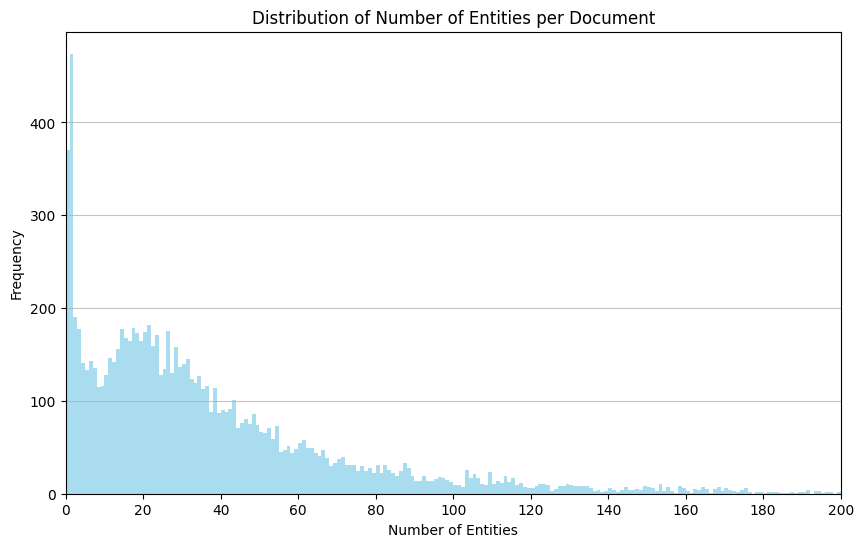

In [82]:
# List to hold the count of entities for each document
entity_counts_per_document = []

# Iterate over each document and count the entities
for document in documents:
    num_entities = len(document["extracted_entities"])
    entity_counts_per_document.append(num_entities)

# Plotting the distribution with x-axis limit
plt.figure(figsize=(10, 6))
plt.hist(entity_counts_per_document, bins=range(min(entity_counts_per_document), max(entity_counts_per_document) + 2), color='skyblue', alpha=0.7)
plt.title('Distribution of Number of Entities per Document')
plt.xlabel('Number of Entities')
plt.ylabel('Frequency')
plt.xlim([0, 200])  # Limiting the x-axis to 200
plt.xticks(range(0, 201, 20))  # Adjusting x-axis ticks for better readability
plt.grid(axis='y', alpha=0.75)
plt.show()

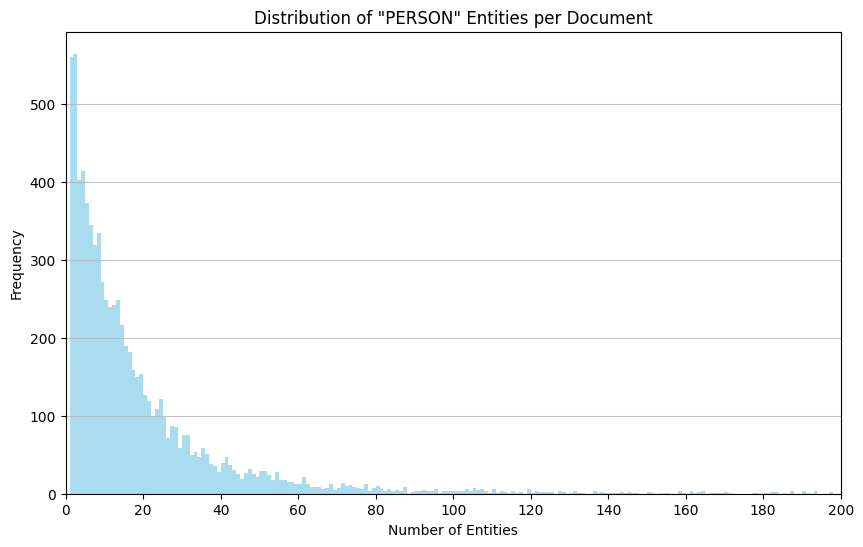

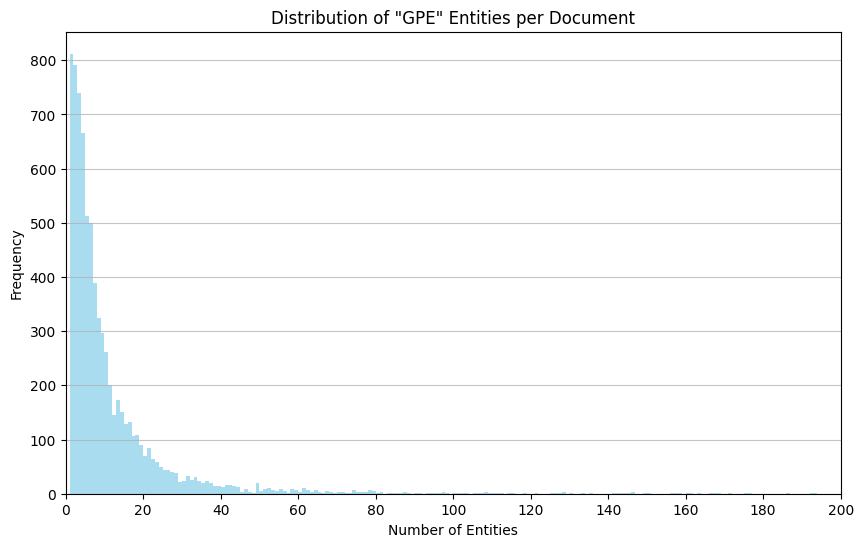

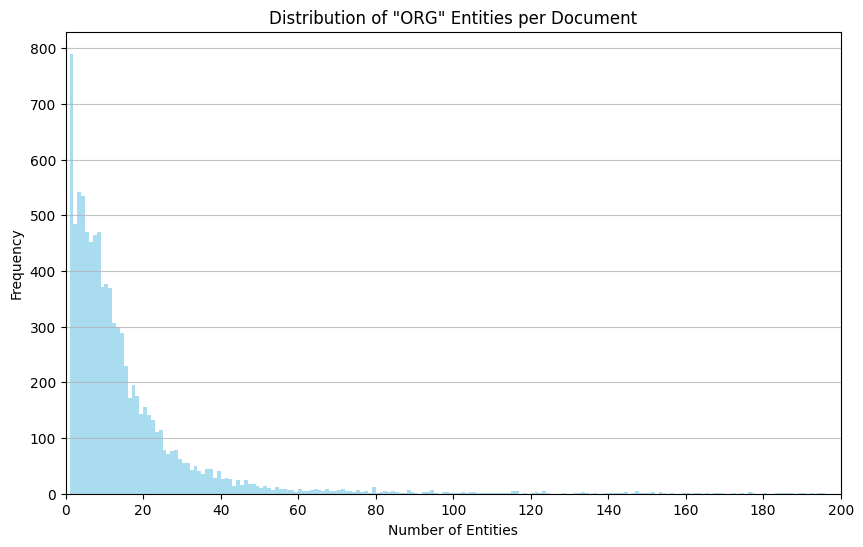

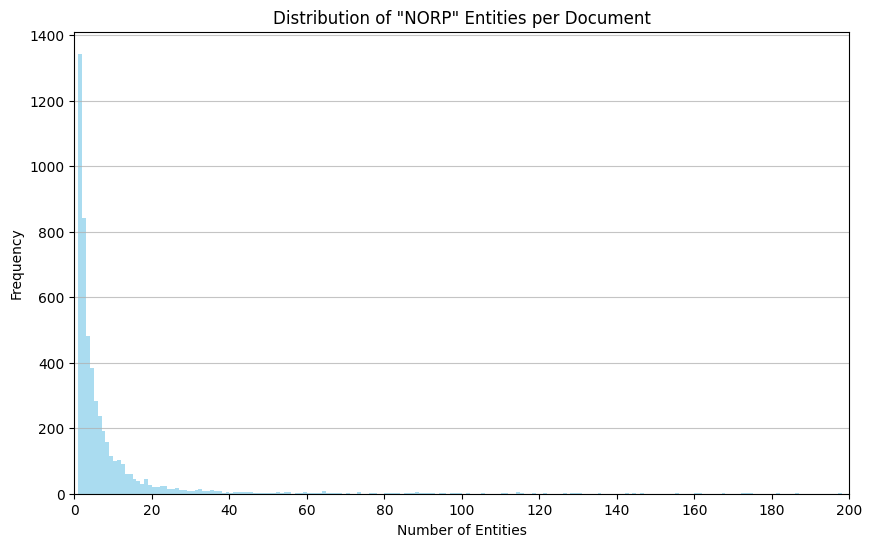

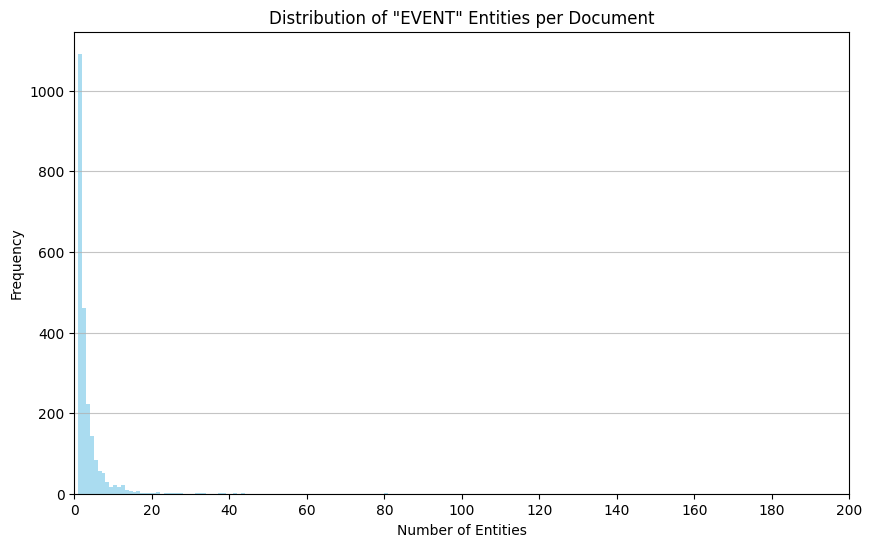

In [15]:
# First, we'll calculate the number of each entity type per document.
entity_type_counts_per_doc = defaultdict(list)

for document in documents:
    # Initialize a count for each entity type in this document
    doc_type_counts = defaultdict(int)
    for entity in document.get("extracted_entities", []):
        doc_type_counts[entity['type']] += 1
    
    # For each entity type, append this document's count to the appropriate list
    for entity_type, count in doc_type_counts.items():
        entity_type_counts_per_doc[entity_type].append(count)

# Now, entity_type_counts_per_doc contains lists of counts for each entity type across all documents.

# Create a separate histogram for each entity type
for entity_type, counts in entity_type_counts_per_doc.items():
    plt.figure(figsize=(10, 6))
    # Calculate bins from 0 to the max count for this entity type + 1 for the range end
    bins_range = range(0, max(counts) + 2)
    plt.hist(counts, bins=bins_range, color='skyblue', alpha=0.7)
    plt.title(f'Distribution of "{entity_type}" Entities per Document')
    plt.xlabel('Number of Entities')
    plt.ylabel('Frequency')
    # Set x-limits based on the counts for readability
    plt.xlim([0, 200])  # Limiting the x-axis to 200
    plt.xticks(range(0, 201, 20))  # Adjusting x-axis ticks for better readability
    plt.grid(axis='y', alpha=0.75)
    plt.show()

### Question: Does the number of entity mentions correlate with the number of "None" values?